# BG/NBD Model with covariates: Issues with parameter a, b recovery


## Imports

In [75]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from fastprogress.fastprogress import progress_bar

from pymc_marketing import clv
from pymc_extras.prior import Prior

from tests.conftest import set_model_fit


# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Replicate the test

### Read the data

In [76]:
data = pd.read_csv("data/clv_quickstart.csv")
data["customer_id"] = data.index
data.head()

,frequency,recency,T,monetary_value,customer_id
0,2,30.43,38.86,22.35,0
1,1,1.71,38.86,11.77,1
2,0,0.00,38.86,0.00,2
3,0,0.00,38.86,0.00,3
4,0,0.00,38.86,0.00,4


### Set artificial covariates

In [77]:
seed = sum(map(ord, "bgnbd-covar"))
rng = np.random.default_rng(seed)

N = data.shape[0]
data["purchase_cov1"] = rng.normal(size=N) / 2
data["purchase_cov2"] = rng.normal(size=N) / 4
data["dropout_cov"] = rng.normal(size=N) / 6
data.head()

,frequency,recency,T,monetary_value,customer_id,purchase_cov1,purchase_cov2,dropout_cov
0,2,30.43,38.86,22.35,0,0.999919,-0.298447,-0.058698
1,1,1.71,38.86,11.77,1,-0.161161,-0.083486,0.138539
2,0,0.00,38.86,0.00,2,-0.060377,0.444374,-0.237762
3,0,0.00,38.86,0.00,3,1.100146,-0.230825,-0.055118
4,0,0.00,38.86,0.00,4,-0.841947,-0.261404,0.085952


### Set the config 

In [78]:
purchase_covariate_cols = ["purchase_cov1", "purchase_cov2"]
dropout_covariate_cols = ["dropout_cov"]

non_nested_priors = dict(
    a_prior=Prior("Uniform", lower=0, upper=1),
    b_prior=Prior("Uniform", lower=0, upper=1),
)
covariate_config = dict(
    purchase_covariate_cols=purchase_covariate_cols,
    dropout_covariate_cols=dropout_covariate_cols,
)

In [79]:
model_with_covariates = clv.BetaGeoModel(
    data,
    model_config={**non_nested_priors, **covariate_config},
)

### Mock fit

In [80]:
true_params = dict(
    a_scale=1,
    b_scale=1,
    alpha_scale=1,
    r=1,
    purchase_coefficient_alpha=np.array([1.0, -2.0]),
    dropout_coefficient_a=np.array([3.0]),
    dropout_coefficient_b=np.array([3.0]),
)

In [81]:
# Mock an idata object for tests requiring a fitted model
chains = 2
draws = 200
n_purchase_covariates = len(purchase_covariate_cols)
n_dropout_covariates = len(dropout_covariate_cols)
mock_fit_dict = {
    "r": rng.normal(true_params["r"], 1e-3, size=(chains, draws)),
    "alpha_scale": rng.normal(
        true_params["alpha_scale"], 1e-3, size=(chains, draws)
    ),
    "a_scale": rng.normal(
        true_params["a_scale"], 1e-3, size=(chains, draws)
    ),
    "b_scale": rng.normal(
        true_params["b_scale"], 1e-3, size=(chains, draws)
    ),
    "purchase_coefficient_alpha": rng.normal(
        true_params["purchase_coefficient_alpha"],
        1e-3,
        size=(chains, draws, n_purchase_covariates),
    ),
    "dropout_coefficient_a": rng.normal(
        true_params["dropout_coefficient_a"],
        1e-3,
        size=(chains, draws, n_dropout_covariates),
    ),
    "dropout_coefficient_b": rng.normal(
        true_params["dropout_coefficient_b"],
        1e-3,
        size=(chains, draws, n_dropout_covariates),
    ),
}
mock_fit_with_covariates = az.from_dict(
    mock_fit_dict,
    dims={
        "purchase_coefficient_alpha": ["purchase_covariate"],
        "dropout_coefficient_a": ["dropout_covariate"],
        "dropout_coefficient_b": ["dropout_covariate"],
    },
    coords={
        "purchase_covariate": purchase_covariate_cols,
        "dropout_covariate": dropout_covariate_cols,
    },
)

set_model_fit(model_with_covariates, mock_fit_with_covariates)

### Set test data

In [82]:
reps = 30
test_data_zero = pd.DataFrame(
    {
        "customer_id": range(3 * reps),
        "frequency": [1, 2, 0] * reps,
        "recency": [7, 5, 2] * reps,
        "purchase_cov1": [0, 0, 0] * reps,
        "purchase_cov2": [0, 0, 0] * reps,
        "dropout_cov": [0, 0, 0] * reps,
        "T": [20, 20, 20] * reps,
        "future_t": [2, 3, 4] * reps,
        "n_purchases": [2, 1, 4] * reps,
    }
)

#### Sampling Distributions

### Sample with zero covariates

In [83]:
res_zero = model_with_covariates.distribution_new_customer(test_data_zero).mean(
    ("chain", "draw")
)

Sampling: [dropout, purchase_rate, recency_frequency]


Output()

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


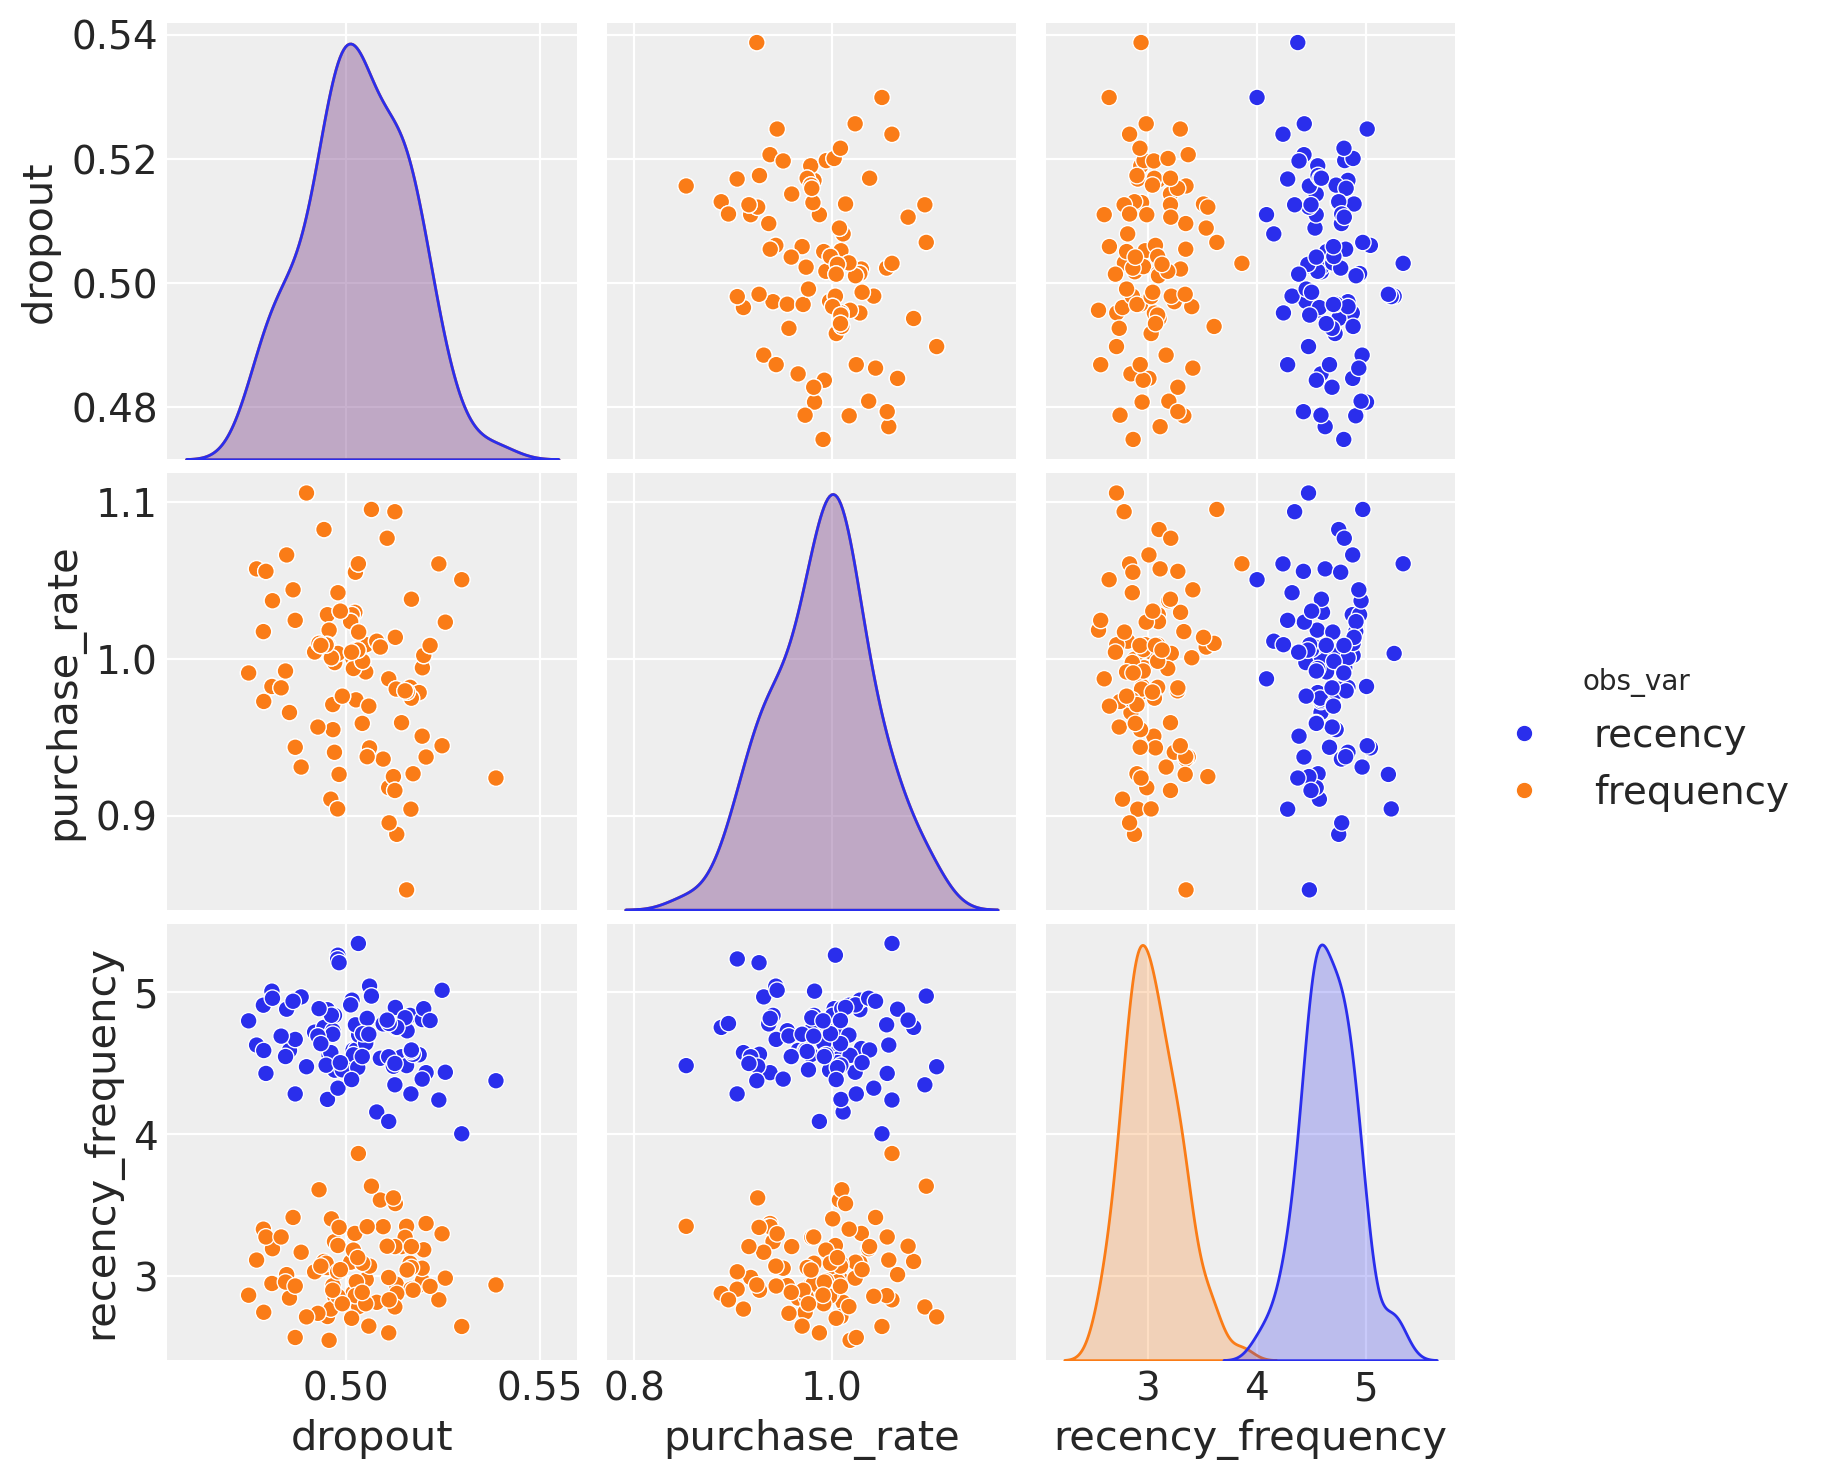

In [84]:
sns.pairplot(res_zero.to_dataframe().reset_index().drop(columns=["customer_id"]), hue="obs_var")

### Sample with covariates

In [85]:
test_data_alt = test_data_zero.assign(
    purchase_cov=1,  # positive coefficient
    purchase_cov2=-1,  # negative coefficient
    dropout_cov=1,  # positive coefficient
)
res_high = model_with_covariates.distribution_new_customer(test_data_alt).mean(
    ("chain", "draw")
)

Sampling: [dropout, purchase_rate, recency_frequency]


Output()

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


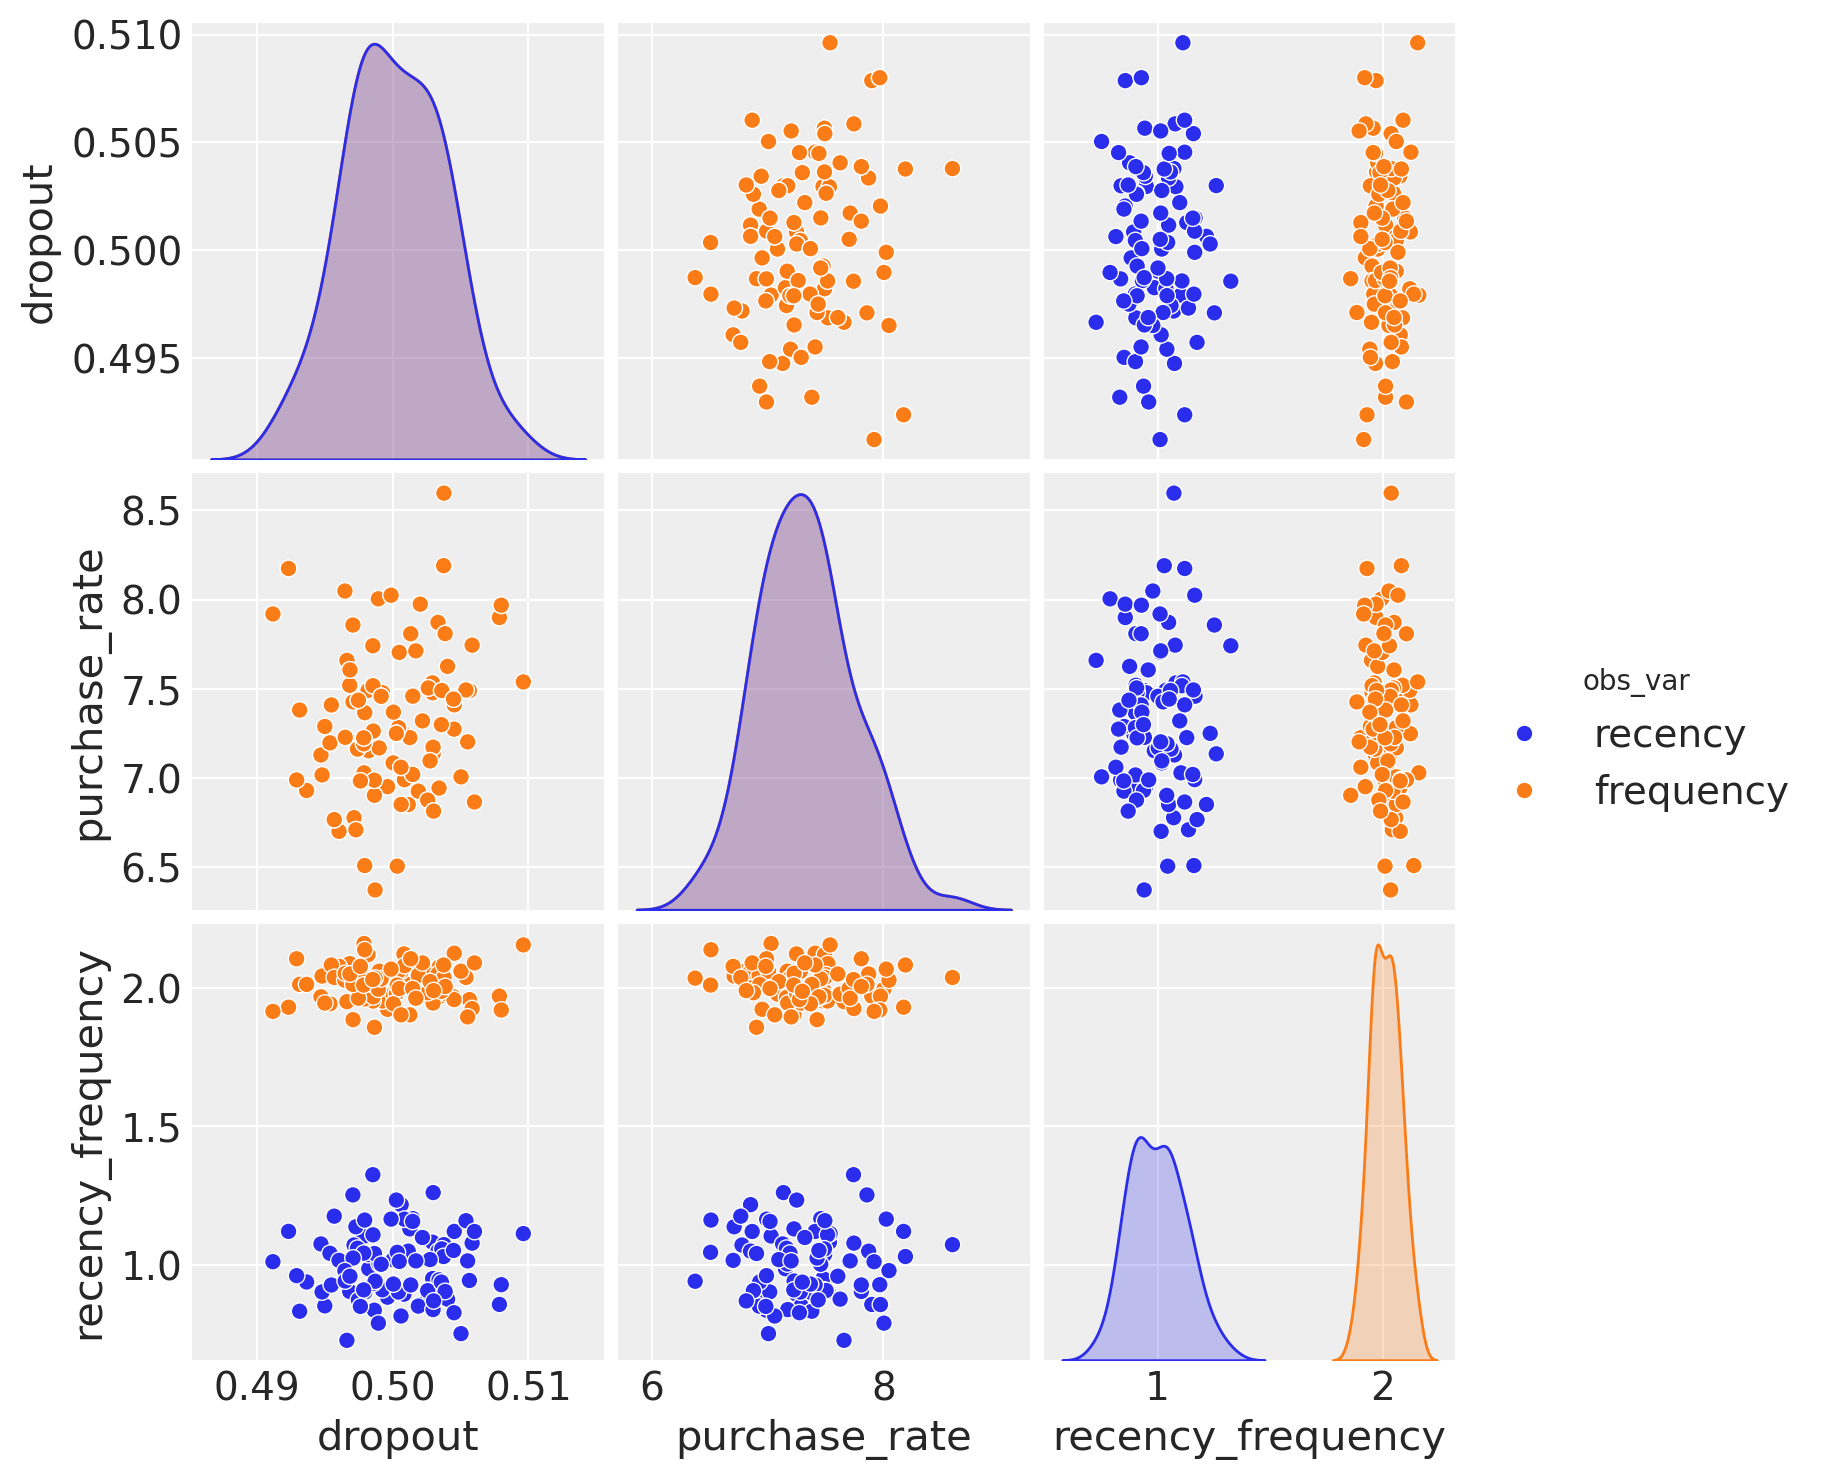

In [86]:
sns.pairplot(res_high.to_dataframe().reset_index().drop(columns=["customer_id"]), hue="obs_var")

### Combine both and inspect the distributions

In [87]:
combined = pd.concat([res_zero.to_dataframe(), res_high.to_dataframe()], keys=["zero", "high"], names=["fit_type"])

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


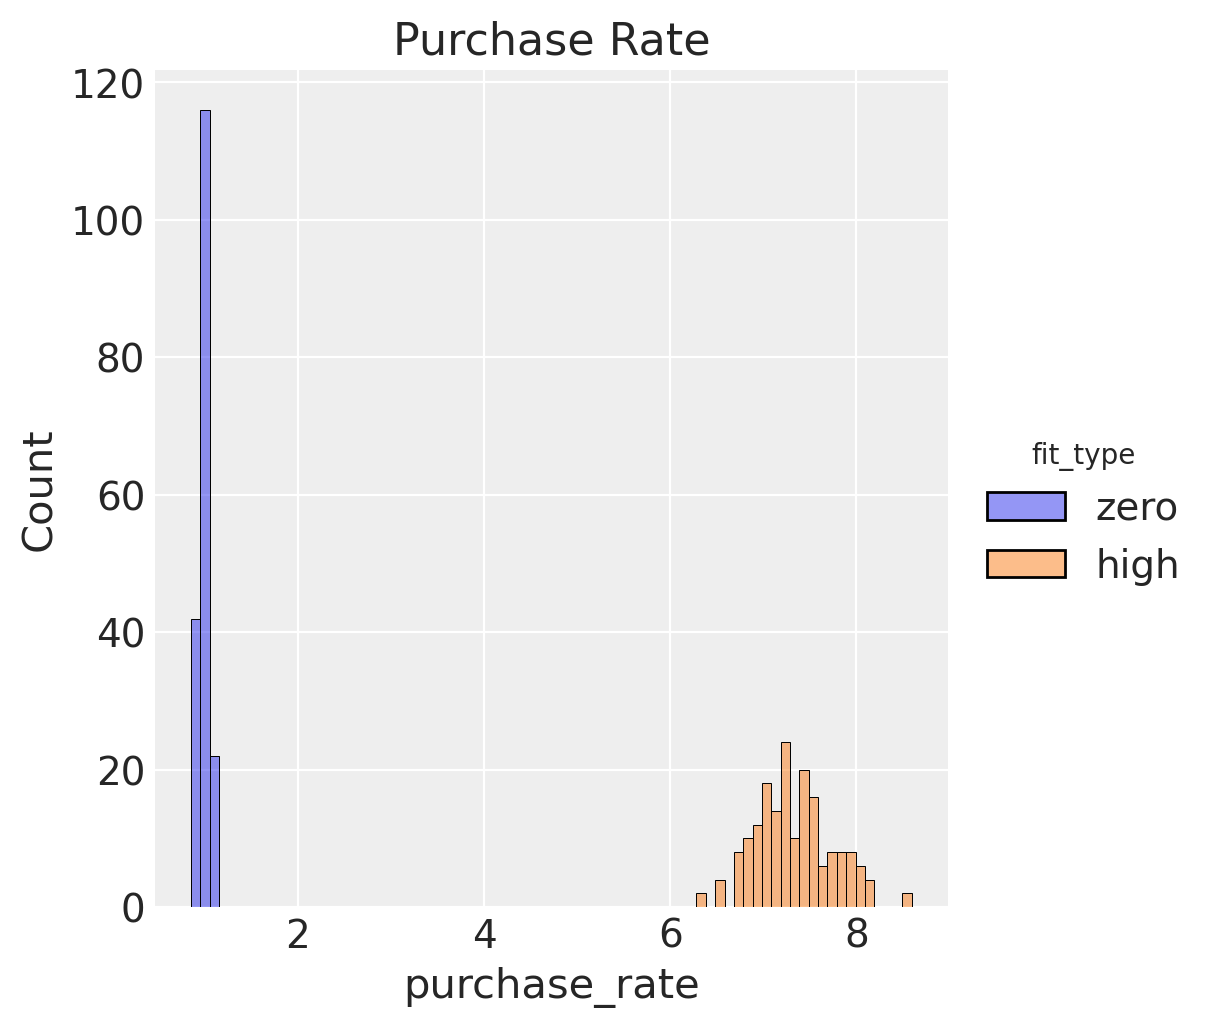

In [88]:
sns.displot(combined, x="purchase_rate", hue="fit_type", binwidth=0.1).set(title="Purchase Rate")

In [89]:
# Assertion
(res_zero["purchase_rate"] < res_high["purchase_rate"]).all()

<xarray.DataArray 'purchase_rate' ()> Size: 1B
array(True)

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


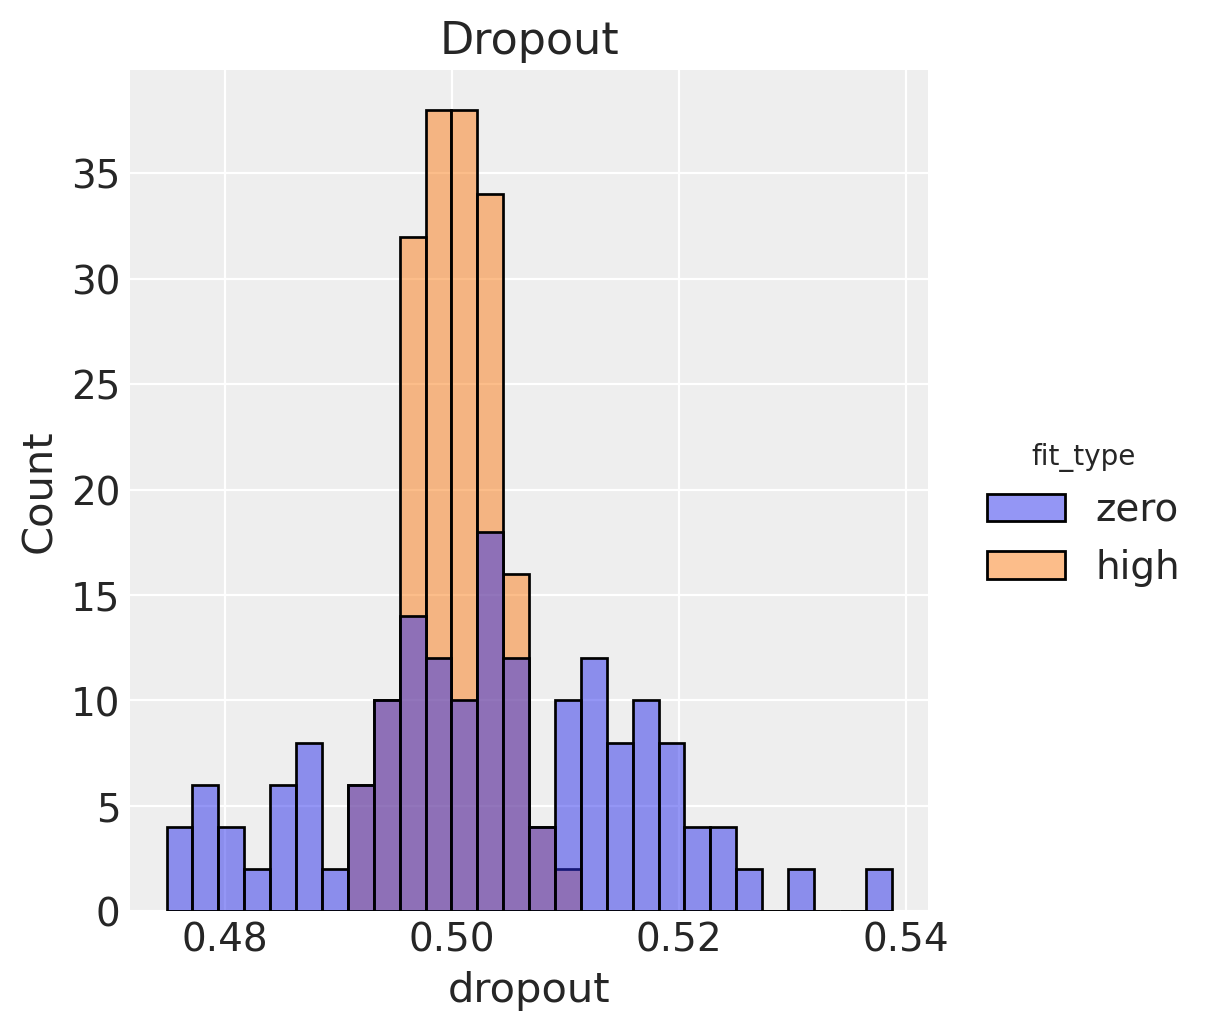

In [90]:
sns.displot(combined, x="dropout", hue="fit_type").set(title="Dropout")

### Dropout is the problematic assertion

The introduction of covariates is not changing the value of the droput probability. We will investigate this below.

In [91]:
# Assertion
(res_zero["dropout"] < res_high["dropout"])

<xarray.DataArray 'dropout' (customer_id: 90)> Size: 90B
array([False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False,  True, False, False, False,  True, False,
        True, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False,  True,  True, False,
        True, False, False, False, False,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True])
Coordinates:
  * customer_id  (customer_id) int64 720B 0 1 2 3 4 5 6 ... 83 84 85 86 87 88 89

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


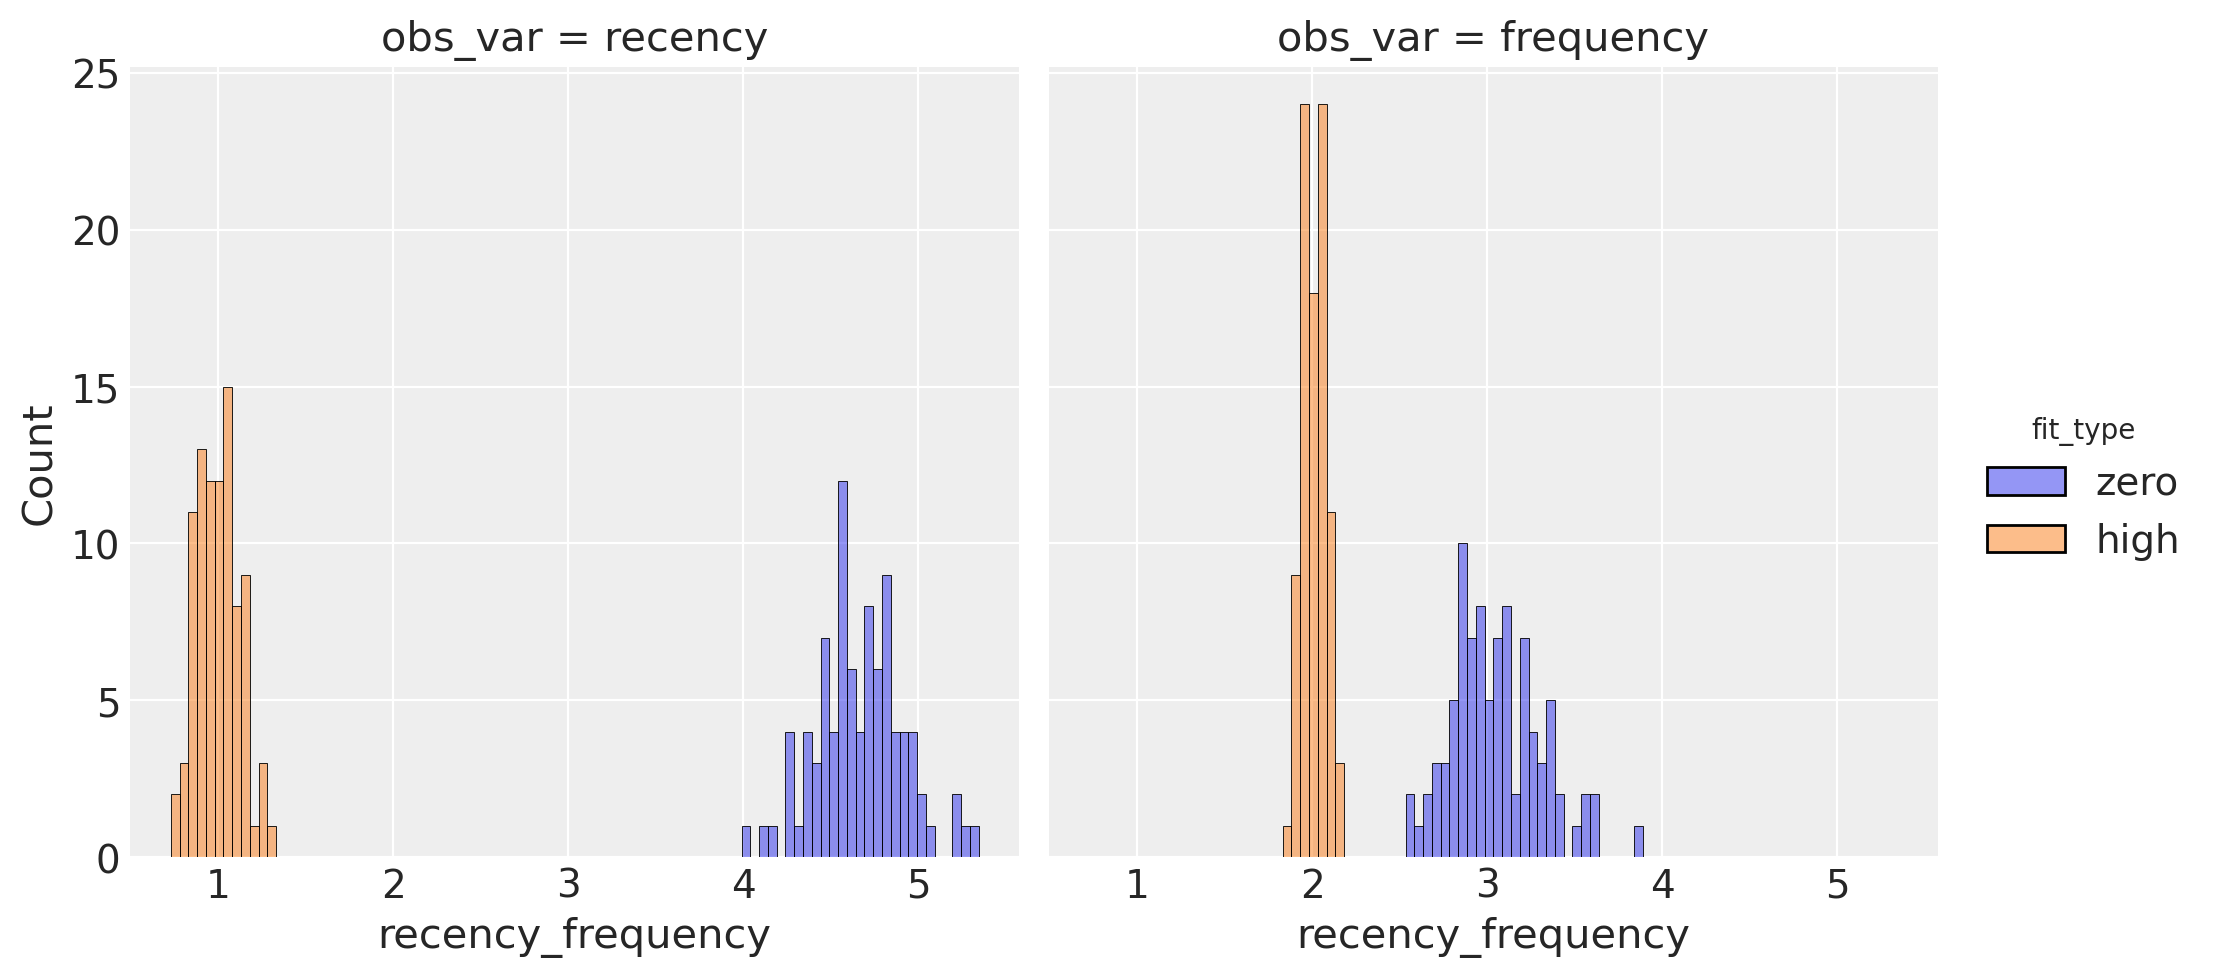

In [92]:
sns.displot(combined, x="recency_frequency", hue="fit_type", col="obs_var", binwidth=0.05) #.set(title="Recency Frequency")

In [93]:
assert (
    res_zero["recency_frequency"].sel(obs_var="frequency")
    > res_high["recency_frequency"].sel(obs_var="frequency")
).all()

In [94]:
assert (
    res_zero["recency_frequency"].sel(obs_var="recency")
    > res_high["recency_frequency"].sel(obs_var="recency")
).all()

## The Beta distribution, and the dropout covariate

In [95]:
import scipy.stats as st

### alpha (a) = beta (b)

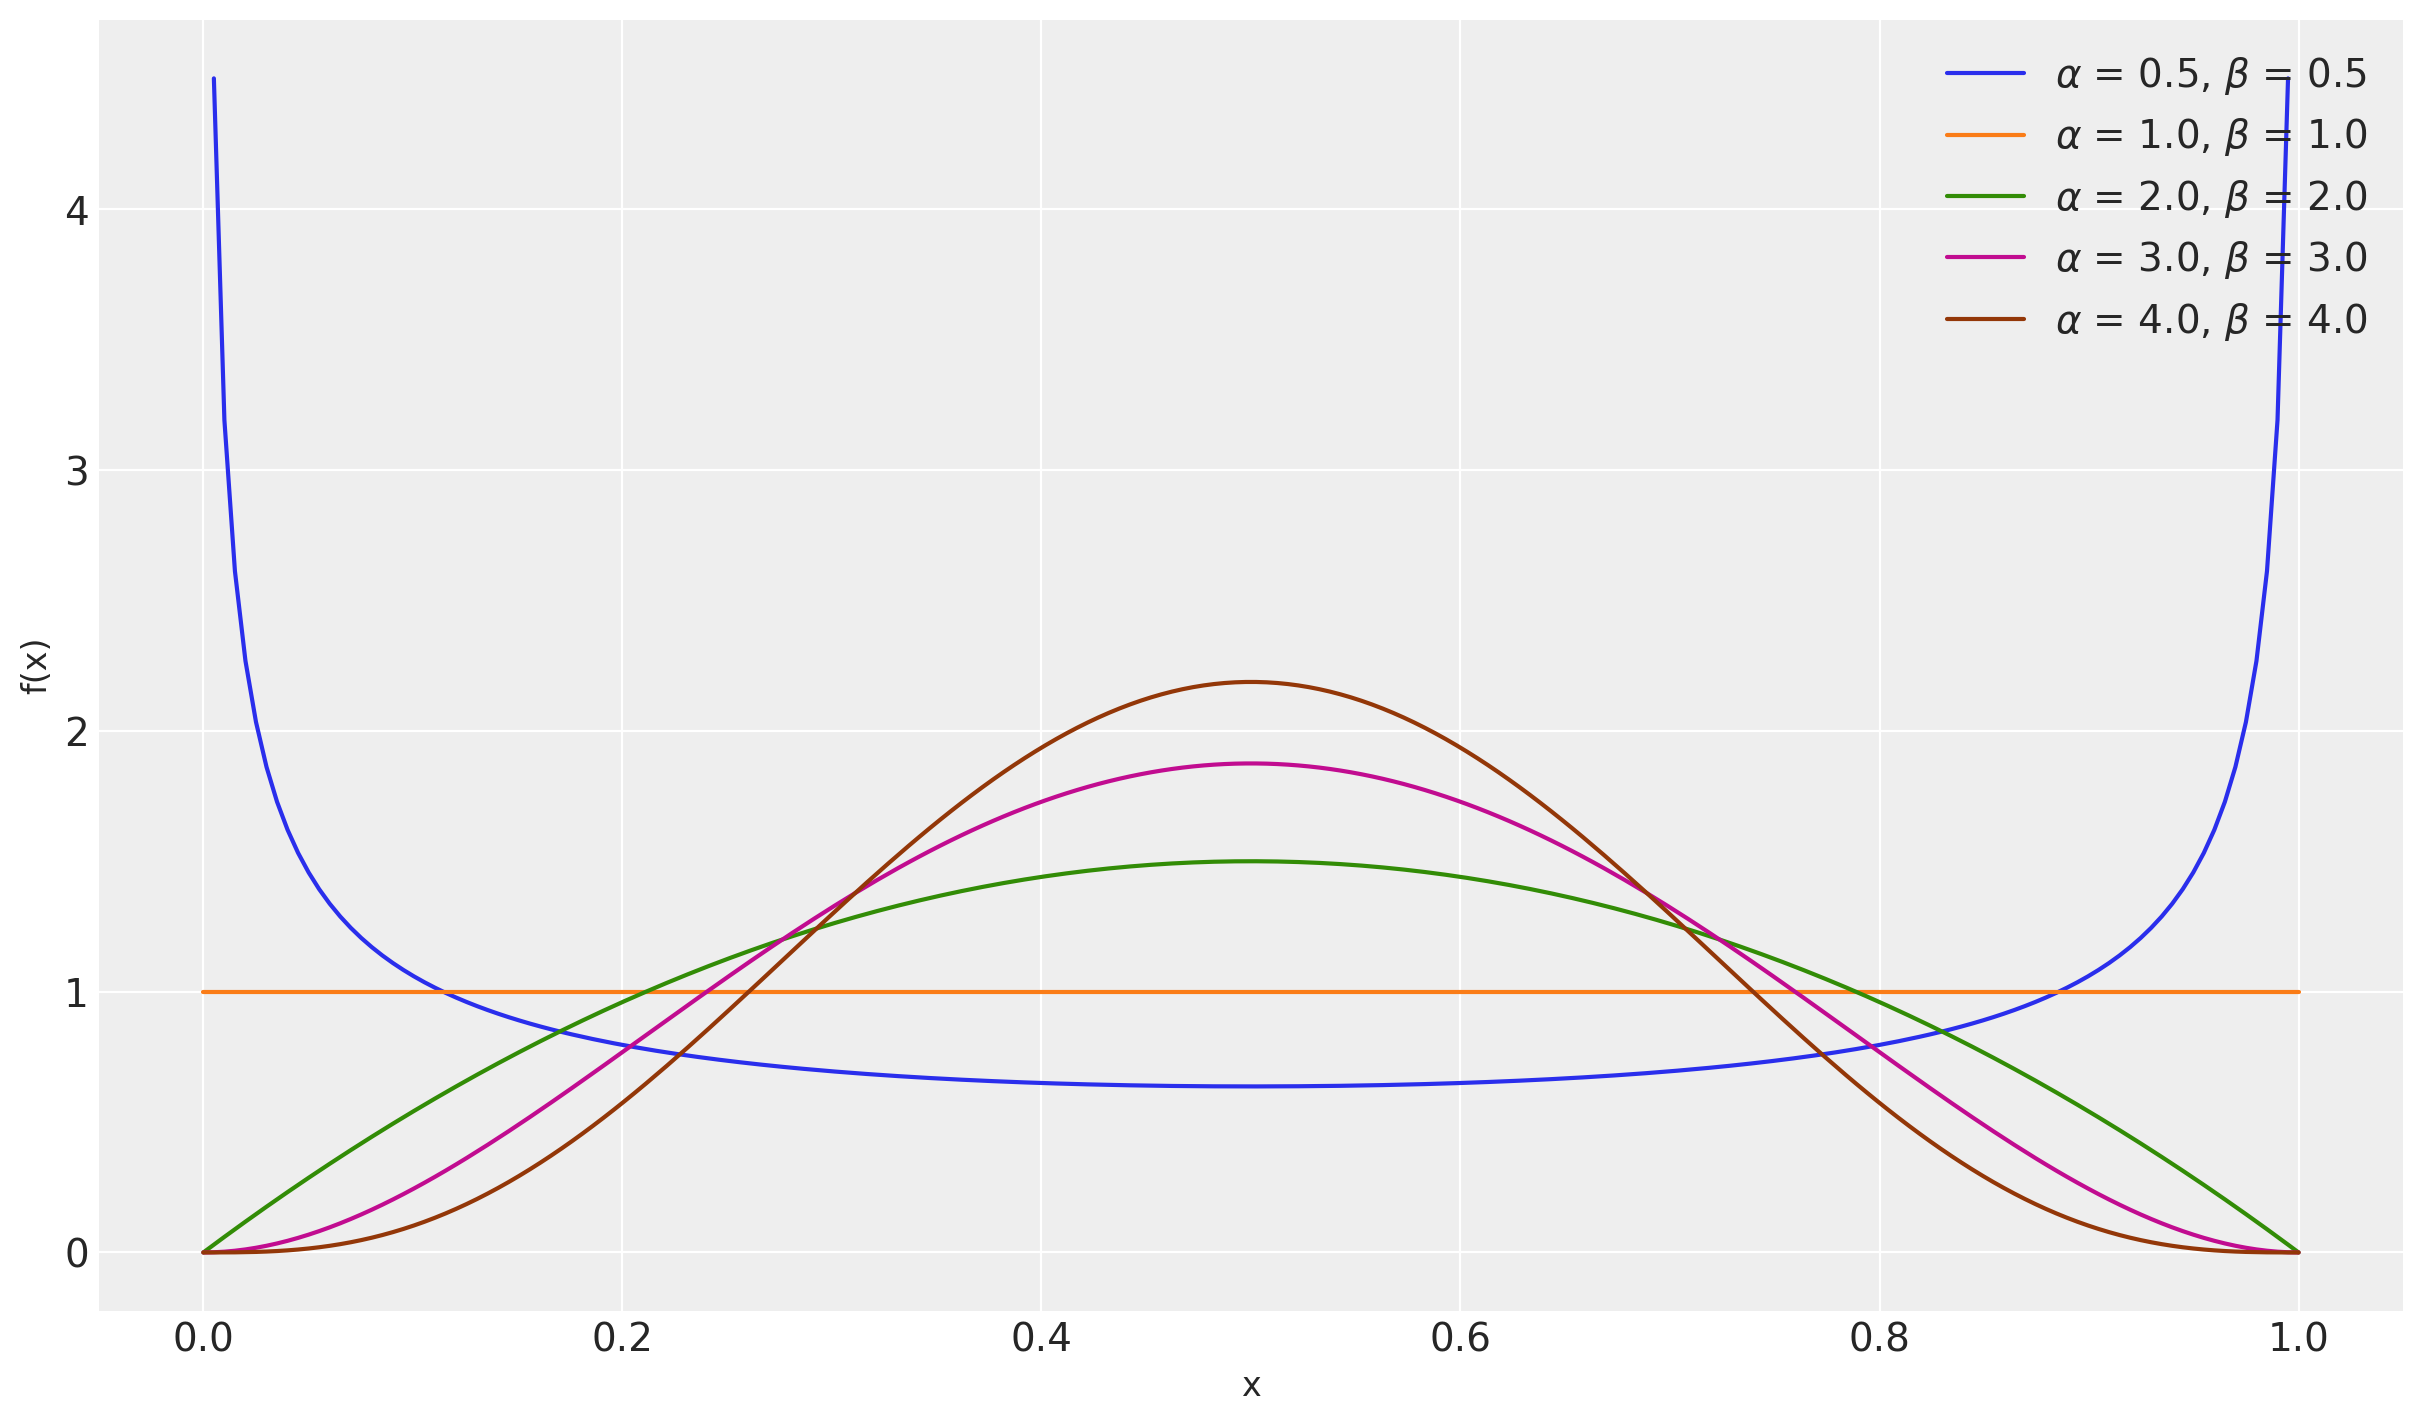

In [108]:
x = np.linspace(0, 1, 200)
alphas = [.5, 1., 2., 3., 4.]
betas = [.5, 1., 2., 3., 4.]
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

Whenever a = b, the Beta distribution is simetrical with E[X] = 0.5. 

This has implications, on the expected values of our *"dropout"* variable. Introducing covariates only narrows our distribution

## alpha (a) > beta (b)

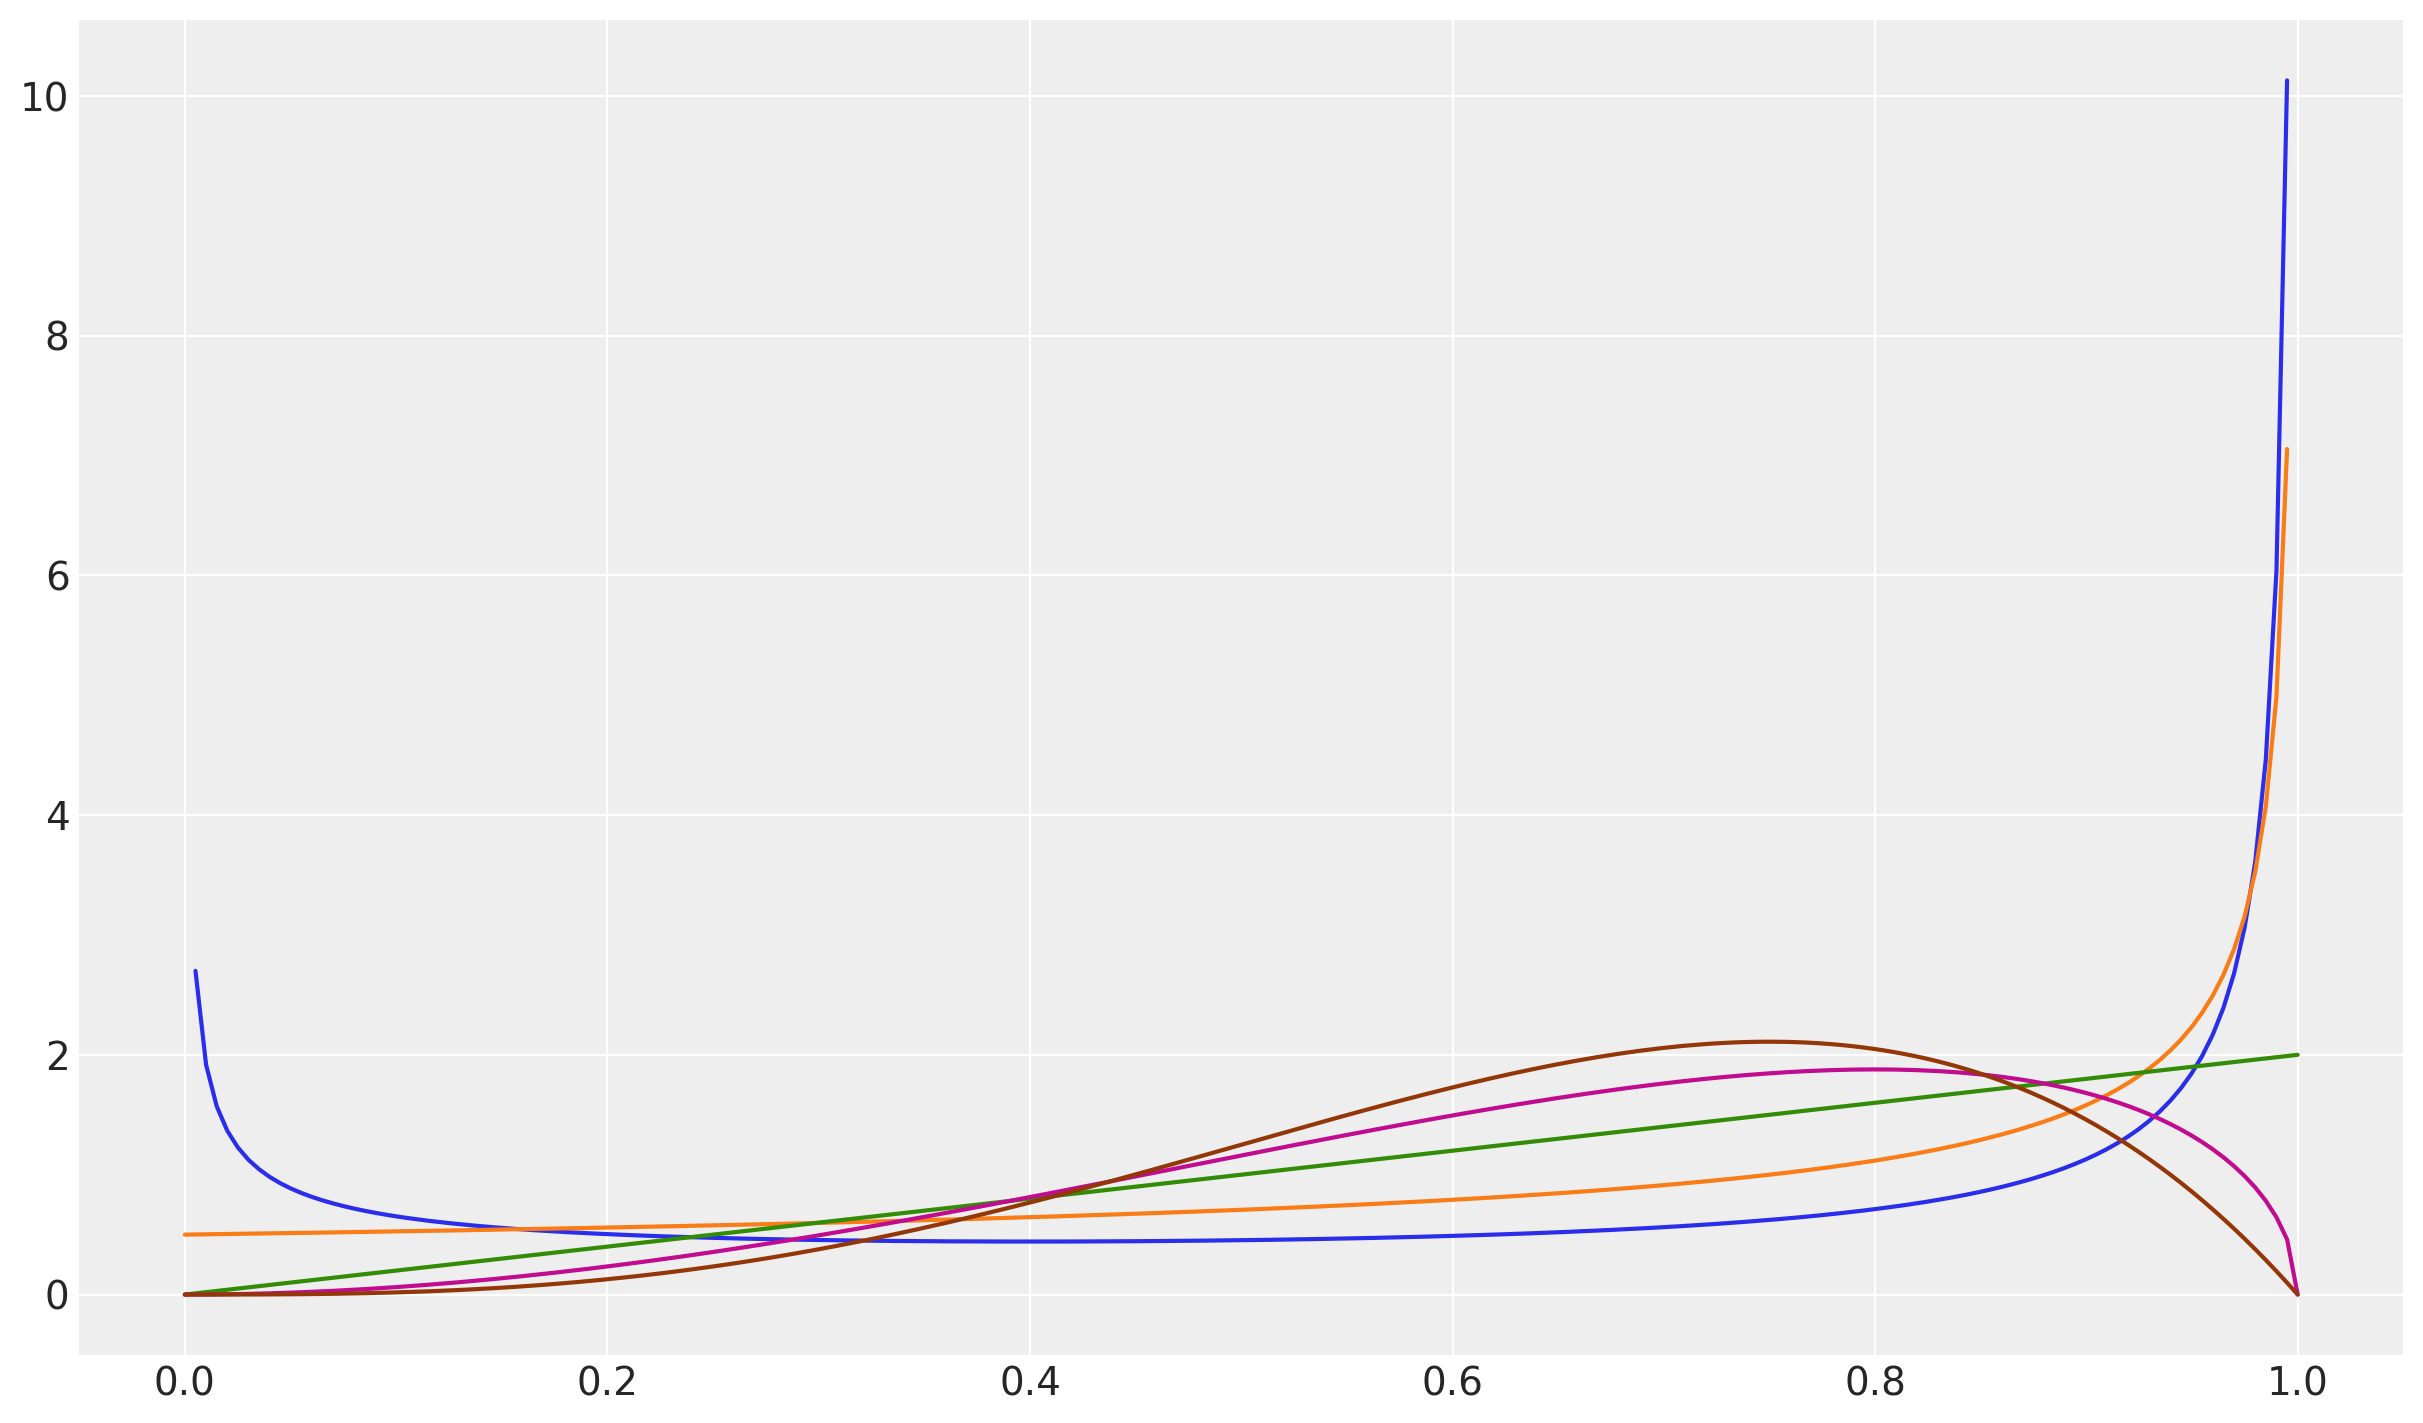

In [98]:
x = np.linspace(0, 1, 200)
alphas = np.array([.5, 1., 2., 3., 4.])
betas = 0.5*alphas
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))

We have E[X] > 0.5

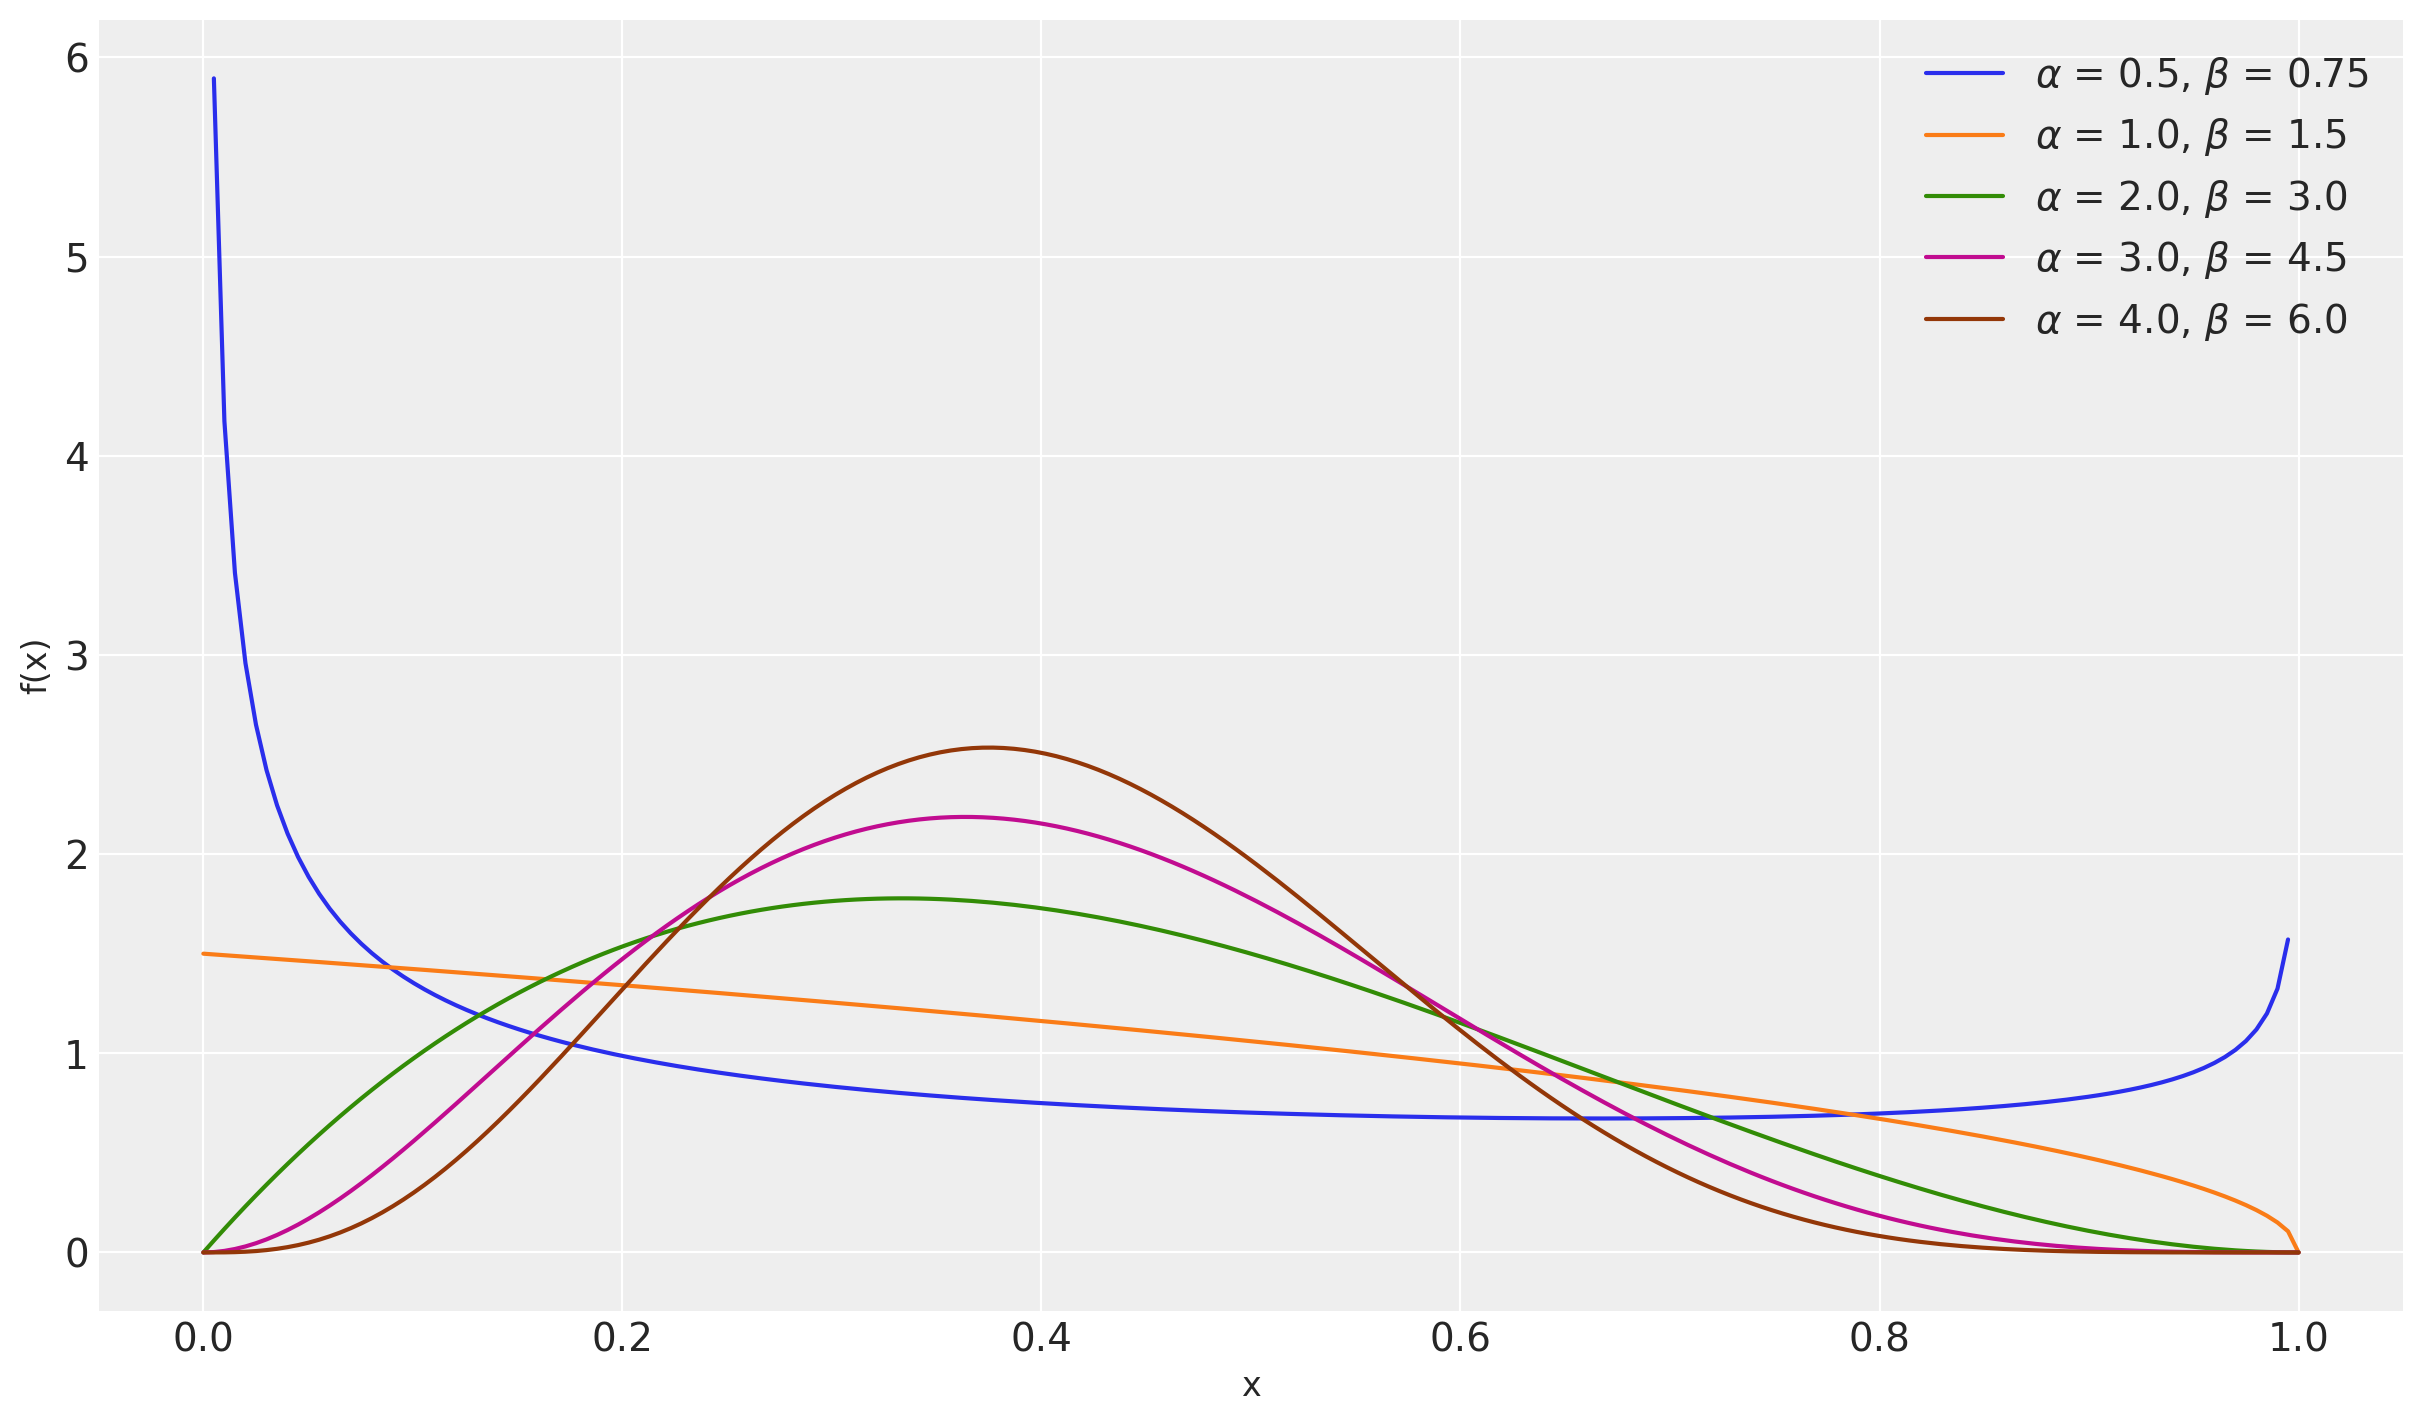

In [106]:
x = np.linspace(0, 1, 200)
alphas = np.array([.5, 1., 2., 3., 4.])
betas = 1.5*alphas
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

We have E[X] < 0.5

## Contrast with ParetoNBD

The ParetoNBD used Gamma for the dropout process,

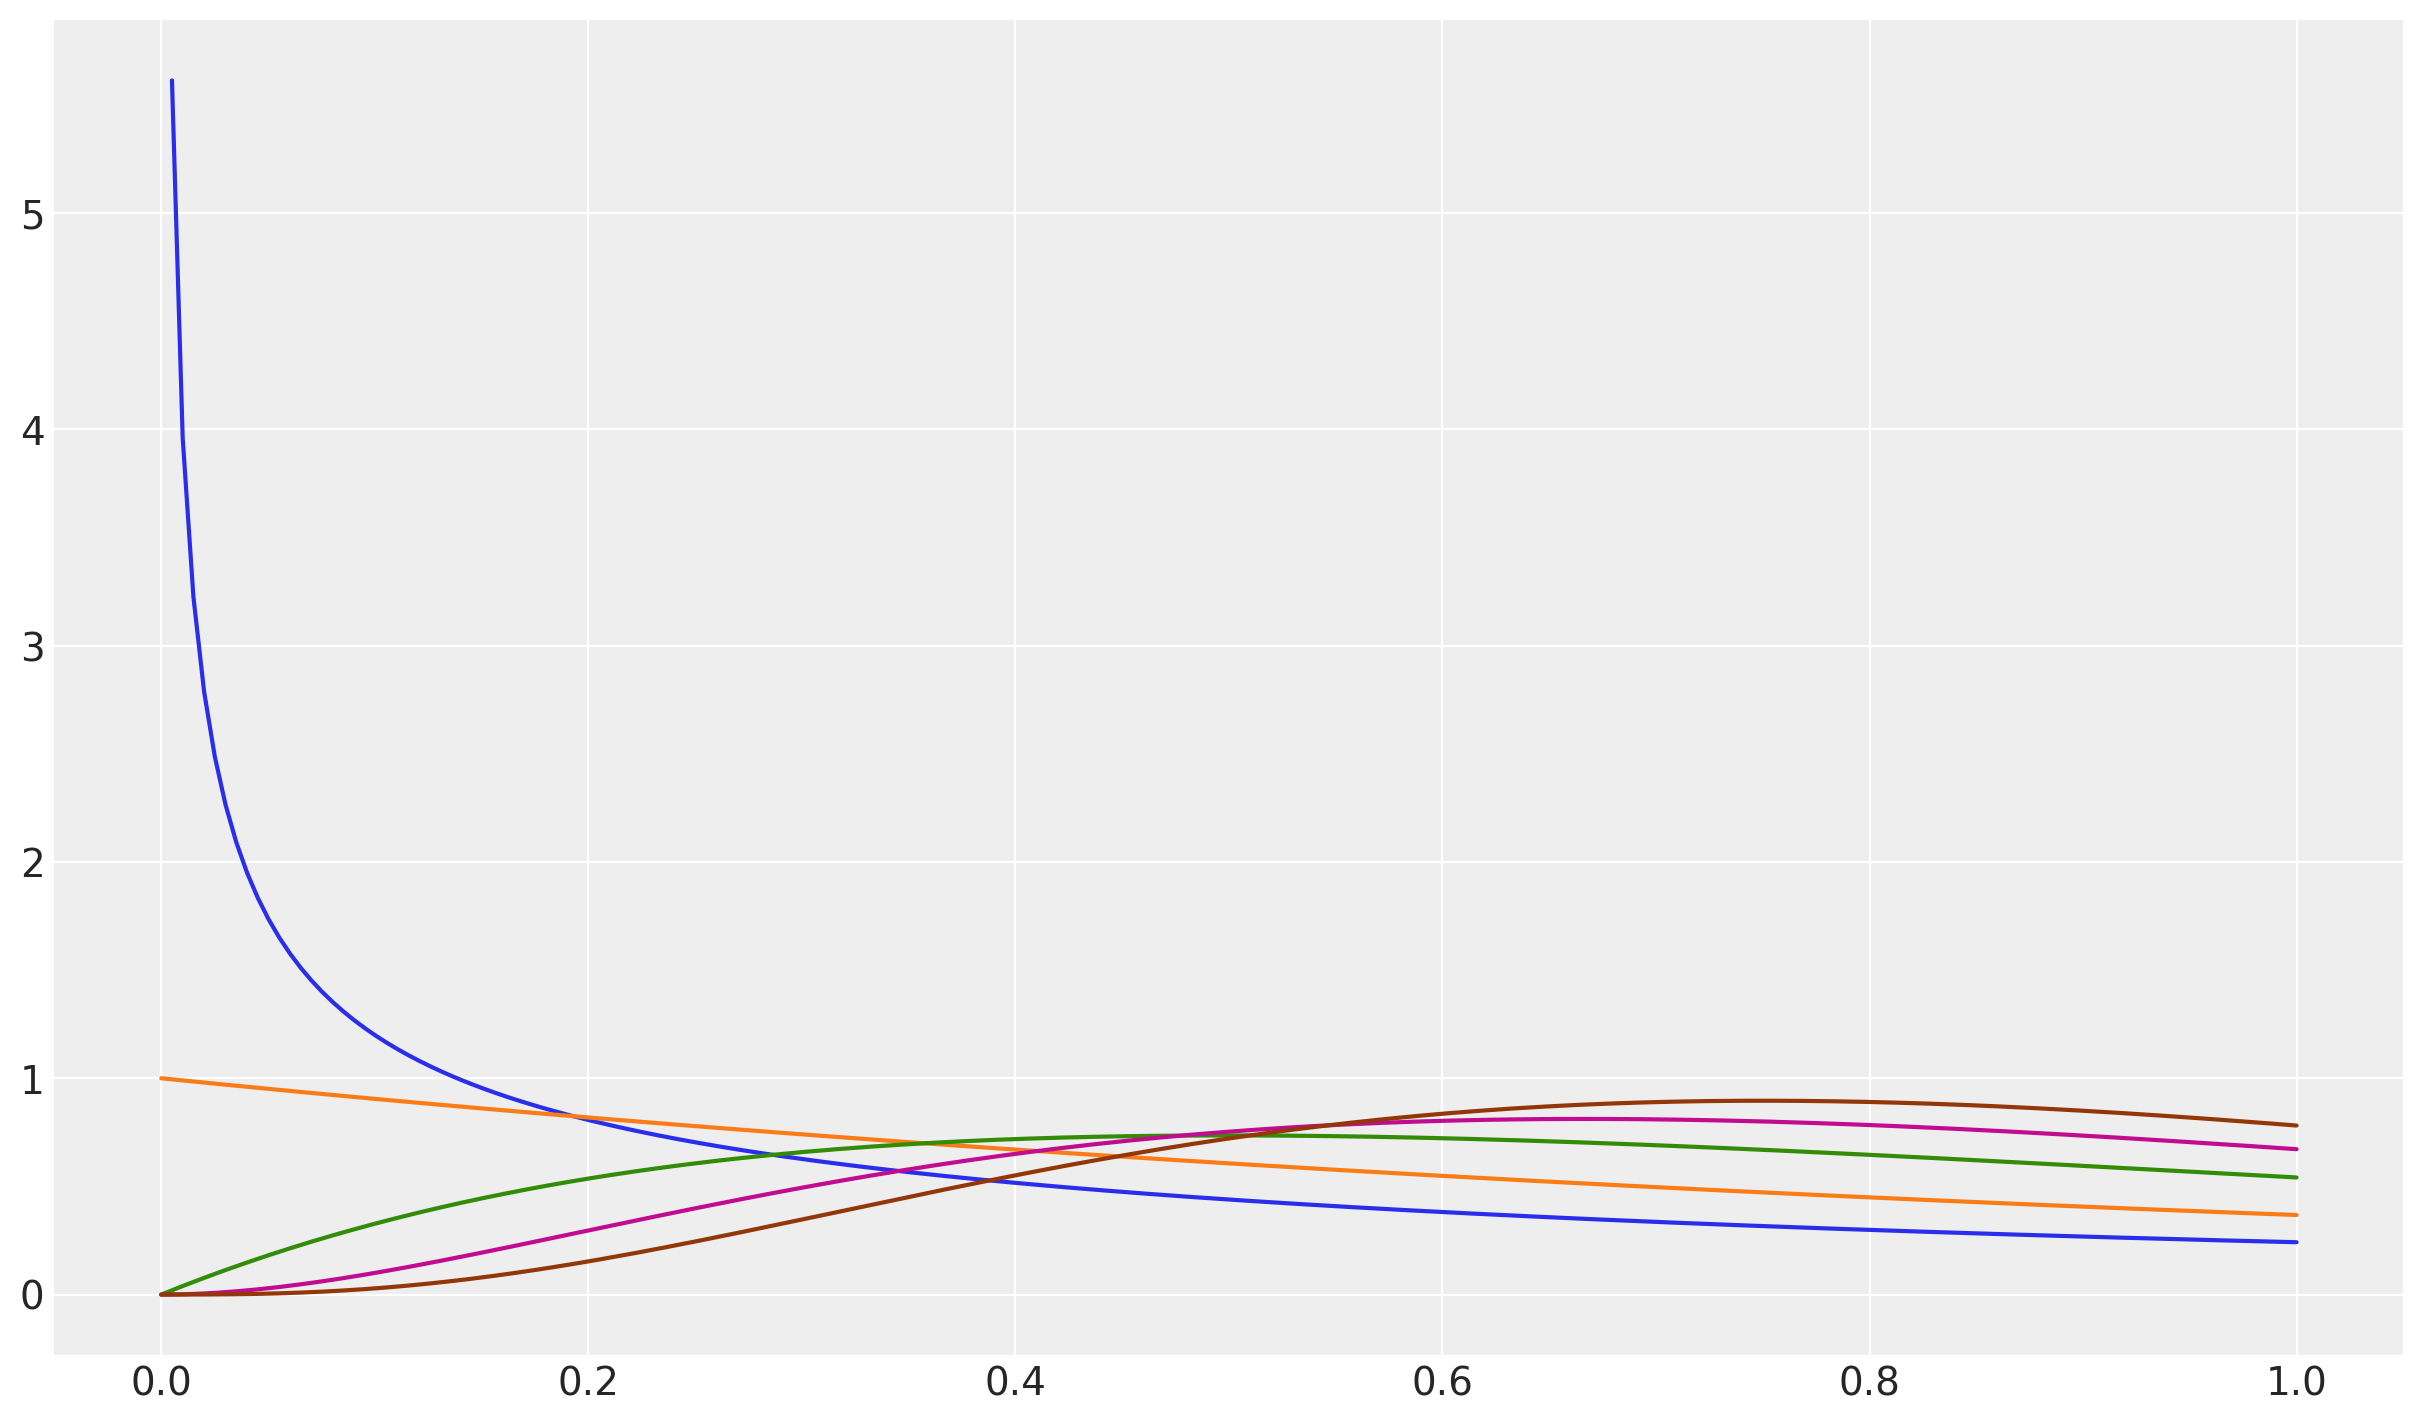

In [ ]:
x = np.linspace(0, 1, 200)
alphas = np.array([.5, 1., 2., 3., 4.])
betas = 2*np.ones_like(alphas)
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

Here we have E[X] monotonically increasing. The presence of covariates increases dropout probability 

## We should change out assertion to:

In [99]:
res_zero["dropout"].std("customer_id") > res_high["dropout"].std("customer_id")

<xarray.DataArray 'dropout' ()> Size: 1B
array(True)

In [100]:
%reload_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Sun Feb 02 2025

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.31.0

pymc    : 5.20.0
pytensor: 2.26.4

xarray        : 2025.1.1
pandas        : 2.2.3
pymc_marketing: 0.11.0
pymc          : 5.20.0
fastprogress  : 1.0.3
numpy         : 1.26.4
arviz         : 0.20.0
scipy         : 1.12.0
seaborn       : 0.13.2
matplotlib    : 3.10.0

Watermark: 2.5.0

